In [ ]:
import os
import json
img_dir = './data/images'
json_file = os.path.join(img_dir, "trainval.json")
with open(json_file) as f:
        imgs_anns = json.load(f)

In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
# !pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 8.3 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44091 sha256=191b2ea07360bfa906822eb569722633d39dba597a8646fe7a5277a0faea21ac
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
     |████████████████████████████████| 6.4 MB 1.8 MB/s 
     |████████████████████████████████| 74 kB 2.7 MB/s 
     |████████████████████████████████| 144 kB 58.7 MB/s 
     |████████████████████████████████| 130 kB 74.1 MB/s 
     |████████████████████████████████| 49 kB 7.7 MB/s 
     |████████████████████████████████| 722 kB 42.0 MB/s 
     |████████████████████████████████| 743 kB 55.0 MB/s 
     |██

In [ ]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
DatasetCatalog.clear()
MetadataCatalog.clear()

In [ ]:
from detectron2.structures import BoxMode

def get_fruit_dicts(img_dir):
    json_file = os.path.join(img_dir, "trainval.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns['images']):
        record = {}
        filename = os.path.join(img_dir, v["file_name"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        objs = []
        for anno in imgs_anns['annotations']:
          if anno['image_id']==idx:
            obj = {
                "bbox": [anno['bbox'][0], anno['bbox'][1], anno['bbox'][2], anno['bbox'][3]],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": anno['category_id']-1,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train"]:
  DatasetCatalog.register("fruit_train", lambda d=d: get_balloon_dicts("data/images")[:15])
  MetadataCatalog.get("fruit_train").set(thing_classes=['date', 'fig', 'hazelnut'])
for d in ["val"]:
  DatasetCatalog.register("fruit_val", lambda d=d: get_balloon_dicts("data/images")[15:])
  MetadataCatalog.get("fruit_val").set(thing_classes=['date', 'fig', 'hazelnut'])


fruit_metadata=  MetadataCatalog.get("fruit_train")

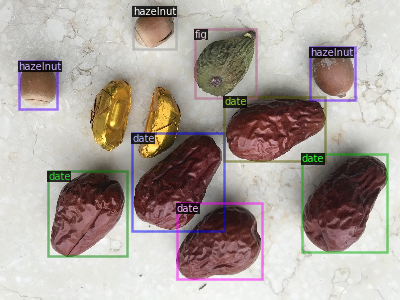

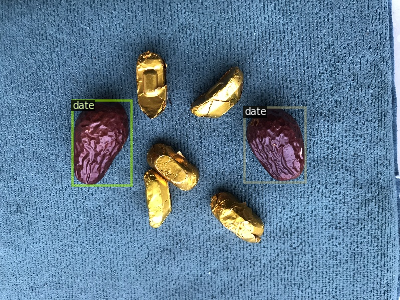

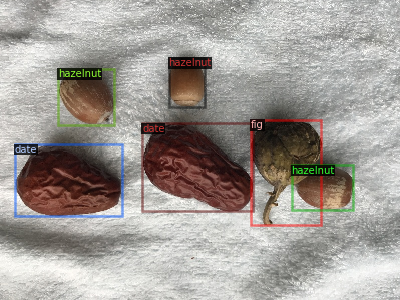

In [ ]:
dataset_dicts = get_fruit_dicts("data/images")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fruit_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.evaluation import COCOEvaluator
from detectron2.engine import DefaultTrainer

class MyTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("fruit_train",)
cfg.DATASETS.TEST = ("fruit_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
cfg.TEST.EVAL_PERIOD = 100
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # three classes['date', 'fig', 'hazelnut']
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = MyTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[08/08 13:44:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[08/08 13:44:16 d2.engine.train_loop]: Starting training from iteration 0
[08/08 13:44:39 d2.utils.events]:  eta: 0:05:11  iter: 19  total_loss: 2.632  loss_cls: 1.516  loss_box_reg: 1.007  loss_rpn_cls: 0.1163  loss_rpn_loc: 0.02132  time: 1.1367  data_time: 0.0159  lr: 1.6068e-05  max_mem: 8536M
[08/08 13:45:03 d2.utils.events]:  eta: 0:05:01  iter: 39  total_loss: 2.091  loss_cls: 1.161  loss_box_reg: 0.8537  loss_rpn_cls: 0.02025  loss_rpn_loc: 0.01749  time: 1.1792  data_time: 0.0056  lr: 3.2718e-05  max_mem: 8536M
[08/08 13:45:26 d2.utils.events]:  eta: 0:04:43  iter: 59  total_loss: 1.764  loss_cls: 0.863  loss_box_reg: 0.9095  loss_rpn_cls: 0.006958  loss_rpn_loc: 0.0143  time: 1.1692  data_time: 0.0065  lr: 4.9367e-05  max_mem: 8536M
[08/08 13:45:52 d2.utils.events]:  eta: 0:04:28  iter: 79  total_loss: 1.615  loss_cls: 0.6808  loss_box_reg: 0.8695  loss_rpn_cls: 0.007864  loss_rpn_loc: 0.01543  time: 1.1952  data_time: 0.0058  lr: 6.6017e-05  max_mem: 8536M
[08/08 13:46:17 d2